In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

!pip install catboost
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


     |████████████████████████████████| 66.2MB 62kB/s 


In [2]:
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train = pd.read_csv("/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/Train.csv")
test = pd.read_csv("/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/Test.csv")
ss = pd.read_csv("/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/sample_submission.csv")

In [4]:
ss.head()

,TARGET(PRICE_IN_LACS)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [5]:
train.head(2)
test.head(2)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.17134,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.00000,0,0,"Panvel,Lalitpur",18.966114,73.148278


In [6]:
TARGET_COL = 'TARGET(PRICE_IN_LACS)'
num_col = ['SQUARE_FT', 'LONGITUDE', 'LATITUDE']
cat_col = ['POSTED_BY', 'BHK_OR_RK']
num_cat_col = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'READY_TO_MOVE', 'RESALE']
text_col = ['ADDRESS']

In [7]:
train[train[TARGET_COL]>20000]
# 10745, 11238, 15724

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
10745,Owner,0,0,3,BHK,2.545455e+08,1,1,"Malur,Bangalore",13.021000,77.938000,28000.0
11238,Dealer,0,0,3,BHK,1.875000e+08,1,1,"R.T. Nagar,Bangalore",13.018900,77.596300,30000.0
15724,Owner,0,0,2,BHK,8.064516e+07,1,1,"Lakkasandra,Bangalore",12.795926,77.331535,25000.0


In [8]:
a = train.index[10745]
b = train.index[11238]
c = train.index[15724]
train = train.drop([a,b,c])
train[train[TARGET_COL]>20000]

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)


In [164]:
df = pd.concat([train,test], axis=0).reset_index(drop=True)

In [165]:
df[cat_col] = df[cat_col].apply(lambda x: pd.factorize(x)[0])

In [166]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [167]:
train.shape, test.shape

((29448, 12), (68720, 11))

# Features Engineering

In [168]:
new_df = pd.DataFrame()
new_df['address_count'] = df['ADDRESS'].apply(lambda x: len(x))
df['address_count'] = new_df['address_count']

In [169]:
new_df['address_ct'] = new_df['address_count'].map(new_df['address_count'].value_counts())

df['address_ct'] = new_df['address_ct']


In [101]:
#df['add_group_posted'] = df.groupby('address_count')['RERA'].transform('nunique')

In [170]:
df['add_group_RESALE'] = df.groupby('ADDRESS')['RESALE'].transform('nunique')
df['add_group_RESALE']

0        1
1        1
2        1
3        1
4        2
        ..
98163    2
98164    2
98165    2
98166    2
98167    2
Name: add_group_RESALE, Length: 98168, dtype: int64

In [171]:
df.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_count,address_ct,add_group_RESALE
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,21,9672,1
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,25,4186,1
2,0,0,0,2,0,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,16,6212,1


In [172]:
new_add = pd.concat([train['ADDRESS'], test['ADDRESS']], axis=0)
adr = new_add.str.split(',', n = 1, expand = True)
df['adr_1'] = list(adr[0])
df['adr_2'] = list(adr[1])

In [173]:
addr = ['adr_2', 'adr_1']

In [174]:
df[addr] = df[addr].apply(lambda x: pd.factorize(x)[0])

In [175]:
df.head(2)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_count,address_ct,add_group_RESALE,adr_1,adr_2
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,21,9672,1,0,0
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,25,4186,1,1,1


In [176]:
df['SQUARE_FT/BHK_NO.'] = df['SQUARE_FT']//df['BHK_NO.']

In [ ]:
#df['Under_const_resale'] = df['UNDER_CONSTRUCTION']*df['RESALE']

In [ ]:
f_name[f_name['import']==0]

In [177]:
temp = df.groupby(['adr_1']).agg({'adr_1':['sum','min','max'],
                                           'POSTED_BY':['count','sum','min','max','mean'],
                                           'UNDER_CONSTRUCTION':['count','sum','mean'],
                                           'RERA':['sum','min','mean'],
                                           'BHK_NO.':['min','max','mean'],
                                           'BHK_OR_RK':['mean'],
                                           'SQUARE_FT':['sum','min','max','mean'],
                                           'RESALE':['sum','min'],
                                           'SQUARE_FT/BHK_NO.': ['sum','min','max','mean']})

temp.columns = ['_'.join(x) for x in temp.columns]
new_df = pd.merge(df,temp,on=['adr_1'],how='left')
#temp.shape
new_df.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_count,address_ct,add_group_RESALE,adr_1,adr_2,SQUARE_FT/BHK_NO.,adr_1_sum,adr_1_min,adr_1_max,POSTED_BY_count,POSTED_BY_sum,POSTED_BY_min,POSTED_BY_max,POSTED_BY_mean,UNDER_CONSTRUCTION_count,UNDER_CONSTRUCTION_sum,UNDER_CONSTRUCTION_mean,RERA_sum,RERA_min,RERA_mean,BHK_NO._min,BHK_NO._max,BHK_NO._mean,BHK_OR_RK_mean,SQUARE_FT_sum,SQUARE_FT_min,SQUARE_FT_max,SQUARE_FT_mean,RESALE_sum,RESALE_min,SQUARE_FT/BHK_NO._sum,SQUARE_FT/BHK_NO._min,SQUARE_FT/BHK_NO._max,SQUARE_FT/BHK_NO._mean
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,21,9672,1,0,0,650.0,0,0,0,2,0,0,0,0.000000,2,0,0.0,0,0,0.000000,2,3,2.500000,0.0,1.300130e+07,1300.236407,1.300000e+07,6.500650e+06,2,1,4333983.0,650.0,4333333.0,2.166992e+06
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,25,4186,1,1,1,637.0,18,1,1,18,13,0,1,0.722222,18,0,0.0,1,0,0.055556,2,5,2.666667,0.0,2.649047e+04,885.156605,2.438529e+03,1.471693e+03,18,1,10087.0,386.0,681.0,5.603889e+02
2,0,0,0,2,0,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,16,6212,1,2,0,466.0,82,2,2,41,3,0,1,0.073171,41,0,0.0,0,0,0.000000,1,3,2.292683,0.0,4.289350e+04,555.041628,1.536127e+03,1.046183e+03,41,1,19041.0,360.0,600.0,4.644146e+02


In [178]:
f_name[f_name['import']==1]

,col,import
6,READY_TO_MOVE,1


In [179]:
temp1 = df.groupby(['adr_2']).agg({'adr_1':['sum','min','max'],
                                           'adr_2':['sum','min'],
                                           'POSTED_BY':['count','sum','max','mean'],
                                           'UNDER_CONSTRUCTION':['count','sum','mean'],
                                           'RERA':['sum','mean'],
                                           'SQUARE_FT':['sum','min','mean'],
                                           'RESALE':['sum','mean'],
                                           'SQUARE_FT/BHK_NO.': ['sum','min','max','mean']
                                   })

temp1.columns = ['_'.join(x) for x in temp1.columns]
new_df = pd.merge(new_df,temp1,on=['adr_2'],how='left')
#temp.shape
new_df.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_count,address_ct,add_group_RESALE,adr_1,adr_2,SQUARE_FT/BHK_NO.,adr_1_sum_x,adr_1_min_x,adr_1_max_x,POSTED_BY_count_x,POSTED_BY_sum_x,POSTED_BY_min,POSTED_BY_max_x,POSTED_BY_mean_x,UNDER_CONSTRUCTION_count_x,UNDER_CONSTRUCTION_sum_x,UNDER_CONSTRUCTION_mean_x,RERA_sum_x,RERA_min,RERA_mean_x,BHK_NO._min,BHK_NO._max,BHK_NO._mean,BHK_OR_RK_mean,SQUARE_FT_sum_x,SQUARE_FT_min_x,SQUARE_FT_max,SQUARE_FT_mean_x,RESALE_sum_x,RESALE_min,SQUARE_FT/BHK_NO._sum_x,SQUARE_FT/BHK_NO._min_x,SQUARE_FT/BHK_NO._max_x,SQUARE_FT/BHK_NO._mean_x,adr_1_sum_y,adr_1_min_y,adr_1_max_y,adr_2_sum,adr_2_min,POSTED_BY_count_y,POSTED_BY_sum_y,POSTED_BY_max_y,POSTED_BY_mean_y,UNDER_CONSTRUCTION_count_y,UNDER_CONSTRUCTION_sum_y,UNDER_CONSTRUCTION_mean_y,RERA_sum_y,RERA_mean_y,SQUARE_FT_sum_y,SQUARE_FT_min_y,SQUARE_FT_mean_y,RESALE_sum_y,RESALE_mean,SQUARE_FT/BHK_NO._sum_y,SQUARE_FT/BHK_NO._min_y,SQUARE_FT/BHK_NO._max_y,SQUARE_FT/BHK_NO._mean_y
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,21,9672,1,0,0,650.0,0,0,0,2,0,0,0,0.000000,2,0,0.0,0,0,0.000000,2,3,2.500000,0.0,1.300130e+07,1300.236407,1.300000e+07,6.500650e+06,2,1,4333983.0,650.0,4333333.0,2.166992e+06,21577265,0,11039,0,0,14260,8063,2,0.565428,14260,1725,0.120968,3794,0.266059,8.633606e+07,30.000035,6054.422061,13710,0.961431,55278406.0,10.0,40163934.0,3876.466059
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,25,4186,1,1,1,637.0,18,1,1,18,13,0,1,0.722222,18,0,0.0,1,0,0.055556,2,5,2.666667,0.0,2.649047e+04,885.156605,2.438529e+03,1.471693e+03,18,1,10087.0,386.0,681.0,5.603889e+02,548347,1,10742,183,1,183,94,2,0.513661,183,11,0.060109,23,0.125683,2.504359e+05,60.000375,1368.502102,175,0.956284,103377.0,12.0,995.0,564.901639
2,0,0,0,2,0,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,16,6212,1,2,0,466.0,82,2,2,41,3,0,1,0.073171,41,0,0.0,0,0,0.000000,1,3,2.292683,0.0,4.289350e+04,555.041628,1.536127e+03,1.046183e+03,41,1,19041.0,360.0,600.0,4.644146e+02,21577265,0,11039,0,0,14260,8063,2,0.565428,14260,1725,0.120968,3794,0.266059,8.633606e+07,30.000035,6054.422061,13710,0.961431,55278406.0,10.0,40163934.0,3876.466059


In [180]:
f_name[f_name['import']==1]

,col,import
6,READY_TO_MOVE,1


In [181]:
temp2 = df.groupby(['SQUARE_FT']).agg({'POSTED_BY':['count','sum','min','max','mean'],
                                        'RERA':['count','sum','min','mean'],
                                        'BHK_NO.':['sum','max','mean'],
                                        'SQUARE_FT':['sum','min'],
                                        'RESALE':['sum','min','mean'],
                                        'SQUARE_FT/BHK_NO.': ['sum','min','max','mean']
                                   })

temp2.columns = ['_'.join(z) for z in temp2.columns]
new_df = pd.merge(new_df,temp2,on=['SQUARE_FT'],how='left')
#temp.shape
new_df.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_count,address_ct,add_group_RESALE,adr_1,adr_2,SQUARE_FT/BHK_NO.,adr_1_sum_x,adr_1_min_x,adr_1_max_x,POSTED_BY_count_x,POSTED_BY_sum_x,POSTED_BY_min_x,POSTED_BY_max_x,POSTED_BY_mean_x,UNDER_CONSTRUCTION_count_x,UNDER_CONSTRUCTION_sum_x,UNDER_CONSTRUCTION_mean_x,RERA_sum_x,RERA_min_x,RERA_mean_x,BHK_NO._min,BHK_NO._max_x,BHK_NO._mean_x,BHK_OR_RK_mean,SQUARE_FT_sum_x,SQUARE_FT_min_x,SQUARE_FT_max,SQUARE_FT_mean_x,...,adr_2_min,POSTED_BY_count_y,POSTED_BY_sum_y,POSTED_BY_max_y,POSTED_BY_mean_y,UNDER_CONSTRUCTION_count_y,UNDER_CONSTRUCTION_sum_y,UNDER_CONSTRUCTION_mean_y,RERA_sum_y,RERA_mean_y,SQUARE_FT_sum_y,SQUARE_FT_min_y,SQUARE_FT_mean_y,RESALE_sum_y,RESALE_mean_x,SQUARE_FT/BHK_NO._sum_y,SQUARE_FT/BHK_NO._min_y,SQUARE_FT/BHK_NO._max_y,SQUARE_FT/BHK_NO._mean_y,POSTED_BY_count,POSTED_BY_sum,POSTED_BY_min_y,POSTED_BY_max,POSTED_BY_mean,RERA_count,RERA_sum,RERA_min_y,RERA_mean,BHK_NO._sum,BHK_NO._max_y,BHK_NO._mean_y,SQUARE_FT_sum,SQUARE_FT_min,RESALE_sum,RESALE_min_y,RESALE_mean_y,SQUARE_FT/BHK_NO._sum,SQUARE_FT/BHK_NO._min,SQUARE_FT/BHK_NO._max,SQUARE_FT/BHK_NO._mean
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,21,9672,1,0,0,650.0,0,0,0,2,0,0,0,0.000000,2,0,0.0,0,0,0.000000,2,3,2.500000,0.0,1.300130e+07,1300.236407,1.300000e+07,6.500650e+06,...,0,14260,8063,2,0.565428,14260,1725,0.120968,3794,0.266059,8.633606e+07,30.000035,6054.422061,13710,0.961431,55278406.0,10.0,40163934.0,3876.466059,51,11,0,1,0.215686,51,3,0,0.058824,129,4,2.529412,66312.056757,1300.236407,51,1,1.000000,27400.0,325.0,650.0,537.254902
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,25,4186,1,1,1,637.0,18,1,1,18,13,0,1,0.722222,18,0,0.0,1,0,0.055556,2,5,2.666667,0.0,2.649047e+04,885.156605,2.438529e+03,1.471693e+03,...,1,183,94,2,0.513661,183,11,0.060109,23,0.125683,2.504359e+05,60.000375,1368.502102,175,0.956284,103377.0,12.0,995.0,564.901639,11,8,0,1,0.727273,11,4,0,0.363636,28,3,2.545455,14025.000000,1275.000000,10,0,0.909091,5735.0,425.0,637.0,521.363636
2,0,0,0,2,0,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,16,6212,1,2,0,466.0,82,2,2,41,3,0,1,0.073171,41,0,0.0,0,0,0.000000,1,3,2.292683,0.0,4.289350e+04,555.041628,1.536127e+03,1.046183e+03,...,0,14260,8063,2,0.565428,14260,1725,0.120968,3794,0.266059,8.633606e+07,30.000035,6054.422061,13710,0.961431,55278406.0,10.0,40163934.0,3876.466059,1,0,0,0,0.000000,1,0,0,0.000000,2,2,2.000000,933.159722,933.159722,1,1,1.000000,466.0,466.0,466.0,466.000000


In [182]:
new_df = new_df.drop(['ADDRESS'], axis=1)

In [183]:
featurs = [c for c in new_df.columns if c not in ['TARGET(PRICE_IN_LACS)']]

In [184]:
featurs

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'LONGITUDE',
 'LATITUDE',
 'address_count',
 'address_ct',
 'add_group_RESALE',
 'adr_1',
 'adr_2',
 'SQUARE_FT/BHK_NO.',
 'adr_1_sum_x',
 'adr_1_min_x',
 'adr_1_max_x',
 'POSTED_BY_count_x',
 'POSTED_BY_sum_x',
 'POSTED_BY_min_x',
 'POSTED_BY_max_x',
 'POSTED_BY_mean_x',
 'UNDER_CONSTRUCTION_count_x',
 'UNDER_CONSTRUCTION_sum_x',
 'UNDER_CONSTRUCTION_mean_x',
 'RERA_sum_x',
 'RERA_min_x',
 'RERA_mean_x',
 'BHK_NO._min',
 'BHK_NO._max_x',
 'BHK_NO._mean_x',
 'BHK_OR_RK_mean',
 'SQUARE_FT_sum_x',
 'SQUARE_FT_min_x',
 'SQUARE_FT_max',
 'SQUARE_FT_mean_x',
 'RESALE_sum_x',
 'RESALE_min_x',
 'SQUARE_FT/BHK_NO._sum_x',
 'SQUARE_FT/BHK_NO._min_x',
 'SQUARE_FT/BHK_NO._max_x',
 'SQUARE_FT/BHK_NO._mean_x',
 'adr_1_sum_y',
 'adr_1_min_y',
 'adr_1_max_y',
 'adr_2_sum',
 'adr_2_min',
 'POSTED_BY_count_y',
 'POSTED_BY_sum_y',
 'POSTED_BY_max_y',
 'POSTED_BY_mean_y',
 'UNDER_CONSTRUCTI

In [185]:
new_df[featurs+[TARGET_COL]] = new_df[featurs+[TARGET_COL]].apply(lambda x: np.log1p(x))
new_df[featurs+[TARGET_COL]].head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,address_count,address_ct,add_group_RESALE,adr_1,adr_2,SQUARE_FT/BHK_NO.,adr_1_sum_x,adr_1_min_x,adr_1_max_x,POSTED_BY_count_x,POSTED_BY_sum_x,POSTED_BY_min_x,POSTED_BY_max_x,POSTED_BY_mean_x,UNDER_CONSTRUCTION_count_x,UNDER_CONSTRUCTION_sum_x,UNDER_CONSTRUCTION_mean_x,RERA_sum_x,RERA_min_x,RERA_mean_x,BHK_NO._min,BHK_NO._max_x,BHK_NO._mean_x,BHK_OR_RK_mean,SQUARE_FT_sum_x,SQUARE_FT_min_x,SQUARE_FT_max,SQUARE_FT_mean_x,RESALE_sum_x,RESALE_min_x,...,POSTED_BY_count_y,POSTED_BY_sum_y,POSTED_BY_max_y,POSTED_BY_mean_y,UNDER_CONSTRUCTION_count_y,UNDER_CONSTRUCTION_sum_y,UNDER_CONSTRUCTION_mean_y,RERA_sum_y,RERA_mean_y,SQUARE_FT_sum_y,SQUARE_FT_min_y,SQUARE_FT_mean_y,RESALE_sum_y,RESALE_mean_x,SQUARE_FT/BHK_NO._sum_y,SQUARE_FT/BHK_NO._min_y,SQUARE_FT/BHK_NO._max_y,SQUARE_FT/BHK_NO._mean_y,POSTED_BY_count,POSTED_BY_sum,POSTED_BY_min_y,POSTED_BY_max,POSTED_BY_mean,RERA_count,RERA_sum,RERA_min_y,RERA_mean,BHK_NO._sum,BHK_NO._max_y,BHK_NO._mean_y,SQUARE_FT_sum,SQUARE_FT_min,RESALE_sum,RESALE_min_y,RESALE_mean_y,SQUARE_FT/BHK_NO._sum,SQUARE_FT/BHK_NO._min,SQUARE_FT/BHK_NO._max,SQUARE_FT/BHK_NO._mean,TARGET(PRICE_IN_LACS)
0,0.000000,0.000000,0.000000,1.098612,0.0,7.171070,0.693147,0.693147,2.636906,4.364346,3.091042,9.177094,0.693147,0.000000,0.000000,6.478510,0.000000,0.000000,0.000000,1.098612,0.000000,0.0,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.0,0.000000,1.098612,1.386294,1.252763,0.0,16.380560,7.171070,16.380460,15.687413,1.098612,0.693147,...,9.565284,8.995165,1.098612,0.448159,9.565284,7.453562,0.114192,8.241440,0.235909,18.273758,3.433988,8.708709,9.525954,0.673674,17.827893,2.397895,17.508480,8.262937,3.951244,2.484907,0.000000,0.693147,0.195309,3.951244,1.386294,0.000000,0.057158,4.867534,1.609438,1.261131,11.102142,7.171070,3.951244,0.693147,0.693147,10.218335,5.786897,6.478510,6.288332,4.025352
1,0.693147,0.000000,0.000000,1.098612,0.0,7.151485,0.693147,0.693147,2.585848,4.352142,3.258097,8.339740,0.693147,0.693147,0.693147,6.458338,2.944439,0.693147,0.693147,2.944439,2.639057,0.0,0.693147,0.543615,2.944439,0.000000,0.000000,0.693147,0.0,0.054067,1.098612,1.791759,1.299283,0.0,10.184578,6.786894,7.799560,7.294848,2.944439,0.693147,...,5.214936,4.553877,1.098612,0.414531,5.214936,2.484907,0.058372,3.178054,0.118390,12.430962,4.110880,7.222203,5.170484,0.671047,11.546147,2.564949,6.903747,6.338420,2.484907,2.197225,0.000000,0.693147,0.546544,2.484907,1.609438,0.000000,0.310155,3.367296,1.386294,1.265666,9.548668,7.151485,2.397895,0.000000,0.646627,8.654517,6.054439,6.458338,6.258364,3.951244
2,0.000000,0.000000,0.000000,1.098612,0.0,6.839647,0.693147,0.693147,2.623076,4.364781,2.833213,8.734399,0.693147,1.098612,0.000000,6.146329,4.418841,1.098612,1.098612,3.737670,1.386294,0.0,0.693147,0.070618,3.737670,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,1.386294,1.191703,0.0,10.666499,6.320843,7.337671,6.953859,3.737670,0.693147,...,9.565284,8.995165,1.098612,0.448159,9.565284,7.453562,0.114192,8.241440,0.235909,18.273758,3.433988,8.708709,9.525954,0.673674,17.827893,2.397895,17.508480,8.262937,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.098612,1.098612,1.098612,6.839647,6.839647,0.693147,0.693147,0.693147,6.146329,6.146329,6.146329,6.146329,3.784190
3,0.000000,0.000000,0.693147,1.098612,0.0,6.836175,0.693147,0.693147,3.389202,4.361116,3.332205,7.984463,0.693147,1.386294,1.098612,6.142037,4.890349,1.386294,1.386294,3.806662,3.295837,0.0,0.693147,0.464306,3.806662,0.000000,0.000000,3.526361,0.0,0.559616,0.693147,1.386294,1.157453,0.0,10.763770,5.707210,7.421182,6.980490,3.806662,0.693147,...,8.189245,7.475906,1.098612,0.398685,8.189245,5.198497,0.048777,7.212294,0.319387,15.342862,3.496508,7.154677,8.173293,0.685201,14.455983,3.496508,8.760610,6.268912,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,1.098612,1.098612,1.098612,6.836175,6.836175,

In [186]:
new_df.isnull().sum().sum()

69028

In [187]:
new_df['LATITUDE'] = new_df['LATITUDE'].fillna(new_df['LATITUDE'].median())
new_df['LONGITUDE'] = new_df['LONGITUDE'].fillna(new_df['LONGITUDE'].median())

In [188]:
new_df.isnull().sum().sum()

68720

In [120]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_test, y_pred):
  return np.sqrt(mean_squared_log_error(y_test, y_pred))

def av_metrices(y_test, y_pred):
  return np.sqrt(mean_squared_error(y_test, y_pred))

In [189]:
trn_proc, test_proc = new_df[:train.shape[0]], new_df[train.shape[0]:].reset_index(drop = True)
features = [c for c in trn_proc.columns if c not in [TARGET_COL]]

In [190]:
test_proc = test_proc.drop(['TARGET(PRICE_IN_LACS)'], axis=1)

In [191]:
trn, val = train_test_split(trn_proc, test_size=0.2, random_state=1)

X_trn, X_val = trn[features], val[features]

y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

X_test = test_proc[features]

In [37]:
from sklearn.model_selection import StratifiedKFold

def clf_run(clf, train, test, features):
  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros(len(test))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits=N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels=False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metrices(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metrices(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

In [38]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(trn_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metrices(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metrices(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:30][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [192]:
plt.style.use('seaborn-whitegrid')

In [40]:
hyper_space = {'n_estimators': [1000, 1500, 2000],
               'max_depth':  [4, 5, 7, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

In [ ]:
clf = RandomizedSearchCV(LGBMRegressor(),
                         hyper_space,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

lgbm = clf.fit(trn_proc[features], trn_proc[TARGET_COL])
lgbm.best_params_


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.281101
Early stopping, best iteration is:
[162]	valid_0's rmse: 0.280623

AV metric score for validation set is 0.2806231711918016

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.283554
[400]	valid_0's rmse: 0.283235
Early stopping, best iteration is:
[244]	valid_0's rmse: 0.283086

AV metric score for validation set is 0.2830857530337283

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.279731
[400]	valid_0's rmse: 0.2805
Early stopping, best iteration is:
[255]	valid_0's rmse: 0.278726

AV metric score for validation set is 0.2787262473552032

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.281994
Early stopping, best iteration is:
[197]	valid_0

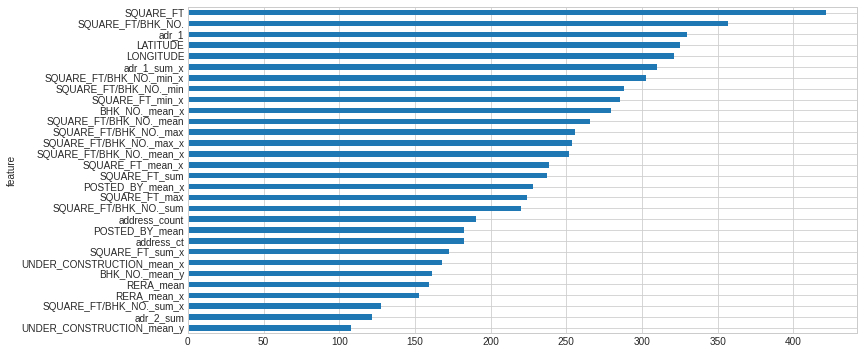

In [193]:
clf = LGBMRegressor(learning_rate = 0.32,
               max_depth = 6,
               min_data_in_leaf = 20,
               num_leaves = 300,
               subsample = 0.6,
               colsample_bytree = 0.7,
               boosting_type= 'gbdt',
               objective= 'regression',
               reg_alpha = 0.67,
               reg_lambda = 0.1,
               n_estimators = 2000,
               metric = None,
               feature_fraction= 0.9,
               bagging_fraction= .9,
               bagging_freq= 70)
fit_params = {'verbose': 200, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [194]:
feat = pd.DataFrame()
feat['col'] = features
feat['import'] = clf.feature_importances_

In [195]:
clf.feature_importances_

array([ 44,  37,  21,  52,   2, 582,   3,   4, 422, 439, 269, 259,   8,
       412, 109, 493, 439,  53,   1, 118, 138,   8,  20, 311,   8, 121,
       220, 111,   4, 230,   9,  57, 364,  20, 224, 390, 285, 338, 109,
         5, 177, 401, 339, 299,  86,  62, 116, 175,  13,  49,  73,   1,
       124,   4,  46, 134,  78, 116,  43, 121, 112,  13, 123,  30,  92,
        93, 101,  64, 100,  11,  11, 284,  12,  88,   2, 265, 138,  49,
       227, 339,  53,  54,   4, 111, 322, 443, 375, 410])

In [197]:
f_name = feat.sort_values(by='import')
f_name[f_name['import']==1]

,col,import
18,adr_1_max_x,1
51,POSTED_BY_max_y,1


In [198]:
lgb_preds_t = np.expm1(lgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = lgb_preds_t
sol_fl.to_csv("sol.csv", index=False)

# CatBoost

In [199]:
cat_params = {'iterations': np.linspace(10, 1000, num=20),
              'depth': np.linspace(1, 10, num=3),
              'learning_rate': np.linspace(0.01, 1.0, num=10),
              'random_strength': np.linspace(1e-9, 10, num=10),
              'bagging_temperature': np.linspace(0.0, 1.0, num=10),
              'border_count': np.linspace(1, 255, num=255),
              'l2_leaf_reg': np.linspace(2, 30, num=2)}

In [ ]:
clf = RandomizedSearchCV(CatBoostRegressor(),
                         cat_params,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

lgbm = clf.fit(trn_proc[features], trn_proc[TARGET_COL])
lgbm.best_params_

Streaming output truncated to the last 5000 lines.
1:	learn: 0.6941666	total: 9.99ms	remaining: 4.98s
2:	learn: 0.6333697	total: 14.7ms	remaining: 4.89s
3:	learn: 0.5713784	total: 19.4ms	remaining: 4.84s
4:	learn: 0.5394970	total: 24.2ms	remaining: 4.81s
5:	learn: 0.5162034	total: 28.8ms	remaining: 4.77s
6:	learn: 0.5064384	total: 33.4ms	remaining: 4.74s
7:	learn: 0.4952611	total: 38.3ms	remaining: 4.75s
8:	learn: 0.4873560	total: 43.2ms	remaining: 4.75s
9:	learn: 0.4819967	total: 48ms	remaining: 4.75s
10:	learn: 0.4730478	total: 52.8ms	remaining: 4.75s
11:	learn: 0.4623530	total: 57.7ms	remaining: 4.75s
12:	learn: 0.4572210	total: 62.5ms	remaining: 4.75s
13:	learn: 0.4524299	total: 67.2ms	remaining: 4.73s
14:	learn: 0.4469862	total: 72ms	remaining: 4.72s
15:	learn: 0.4421426	total: 76.8ms	remaining: 4.72s
16:	learn: 0.4384545	total: 82.9ms	remaining: 4.79s
17:	learn: 0.4356112	total: 88.1ms	remaining: 4.8s
18:	learn: 0.4327459	total: 92.8ms	remaining: 4.79s
19:	learn: 0.4307524	total:

{'bagging_temperature': 0.8888888888888888,
 'border_count': 155.0,
 'depth': 1.0,
 'iterations': 1000.0,
 'l2_leaf_reg': 30.0,
 'learning_rate': 0.89,
 'random_strength': 3.333333334}

In [200]:
cat_par = {'n_estimators': 2000,
           'border_count': 89.0,
           'depth': 6.0,
           'l2_leaf_reg': 30.0,
           'learning_rate': 0.33,
           'random_strength': 4.45,
           'rsm' : 0.4,
           'random_state':10}


------------- Fold 1 -------------
0:	learn: 0.7280032	test: 0.7225991	best: 0.7225991 (0)	total: 61.6ms	remaining: 2m 3s
200:	learn: 0.2589006	test: 0.2839821	best: 0.2839821 (200)	total: 2.46s	remaining: 22.1s
400:	learn: 0.2224370	test: 0.2747078	best: 0.2746437 (399)	total: 4.86s	remaining: 19.4s
600:	learn: 0.1997748	test: 0.2723475	best: 0.2723475 (600)	total: 7.27s	remaining: 16.9s
800:	learn: 0.1816662	test: 0.2707303	best: 0.2707228 (798)	total: 9.69s	remaining: 14.5s
1000:	learn: 0.1679280	test: 0.2698008	best: 0.2696852 (994)	total: 12.1s	remaining: 12.1s
1200:	learn: 0.1563358	test: 0.2701545	best: 0.2695897 (1010)	total: 14.6s	remaining: 9.69s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2695897211
bestIteration = 1010

Shrink model to first 1011 iterations.

AV metric score for validation set is 0.2695897204300224

------------- Fold 2 -------------
0:	learn: 0.7248739	test: 0.7400598	best: 0.7400598 (0)	total: 13.2ms	remaining: 26.4s
200:	learn: 

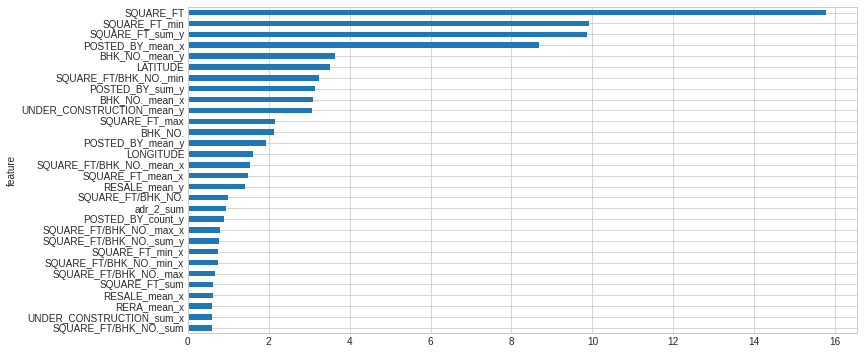

In [201]:
clf = CatBoostRegressor(**cat_par)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [ ]:
cb_preds_t = np.expm1(cb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = cb_preds_t
sol_fl.to_csv("catboost.csv", index=False)

In [202]:
clf.feature_importances_

array([3.14273833e-01, 7.15002086e-02, 6.32898040e-02, 2.17469615e+00,
       2.44141587e-03, 1.67919076e+01, 2.03597941e-01, 1.01474823e-02,
       1.83384685e+00, 3.24322434e+00, 4.35655695e-01, 4.78865708e-01,
       9.98125463e-03, 3.43704545e-01, 4.46380983e-01, 8.83133561e-01,
       5.22096010e-01, 3.13865476e-01, 2.13585334e-01, 5.70400776e-01,
       3.09985138e-01, 1.37444018e-01, 3.76881899e-01, 8.53204784e+00,
       2.25004630e-01, 6.04048543e-01, 5.79591225e-01, 2.19079047e-01,
       3.09312652e-02, 5.99238172e-01, 2.29893302e-02, 2.30156939e-01,
       2.78151933e+00, 8.77471703e-02, 2.94508294e-01, 7.53282103e-01,
       2.23244780e+00, 2.08795096e+00, 3.55641302e-01, 3.34957475e-02,
       2.97661845e-01, 8.65202640e-01, 8.75724869e-01, 1.34450264e+00,
       5.34090716e-01, 1.95481042e-01, 2.83340430e-01, 1.29590346e+00,
       6.28262245e-02, 9.61309758e-01, 3.11155062e+00, 5.83134021e-02,
       2.19844589e+00, 1.49063968e-01, 5.16616046e-01, 2.76181246e+00,
      

# XGBoost


------------- Fold 1 -------------
[11:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.5886
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.269818
[400]	validation_0-rmse:0.270036
Stopping. Best iteration:
[212]	validation_0-rmse:0.269482


AV metric score for validation set is 0.2694825700462236

------------- Fold 2 -------------
[11:19:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.59504
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.283035
[400]	validation_0-rmse:0.283086
Stopping. Best iteration:
[225]	validation_0-rmse:0.282714


AV metric score for validation set is 0.28271364769112123

------------- Fold 3 -------------
[11:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear

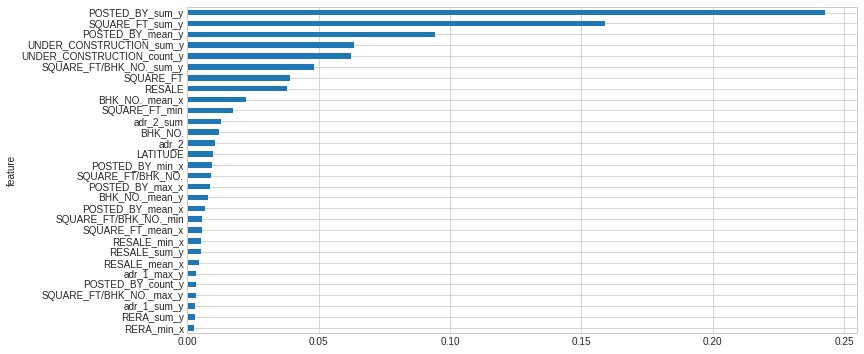

In [203]:
clf = XGBRegressor(n_estimators = 2000,
                    max_depth = 6,
                    learning_rate = 0.33,
                    colsample_bytree = 0.7,
                    random_state=10,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [204]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds

In [205]:
sol_fl.to_csv("kFold_xg.csv", index=False)

In [206]:
fi

feature
RERA_min_x                    0.002699
RERA_sum_y                    0.002864
adr_1_sum_y                   0.002935
SQUARE_FT/BHK_NO._max_y       0.003184
POSTED_BY_count_y             0.003350
adr_1_max_y                   0.003448
RESALE_mean_x                 0.004616
RESALE_sum_y                  0.005038
RESALE_min_x                  0.005203
SQUARE_FT_mean_x              0.005570
SQUARE_FT/BHK_NO._min         0.005582
POSTED_BY_mean_x              0.006652
BHK_NO._mean_y                0.007921
POSTED_BY_max_x               0.008587
SQUARE_FT/BHK_NO.             0.008879
POSTED_BY_min_x               0.009518
LATITUDE                      0.009685
adr_2                         0.010402
BHK_NO.                       0.012131
adr_2_sum                     0.013004
SQUARE_FT_min                 0.017476
BHK_NO._mean_x                0.022457
RESALE                        0.037914
SQUARE_FT                     0.039175
SQUARE_FT/BHK_NO._sum_y       0.048118
UNDER_CONSTRUCTIO

# Ensembling

In [209]:
av_metrices(np.log1p(train[TARGET_COL]), lgb_oofs*0.20 + cb_oofs*0.45 + xgb_oofs*0.35)

0.26800482651634605

In [210]:
train_new = train[[TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = pd.DataFrame()

train_new['lgb'] = 0.2*lgb_oofs
test_new['lgb'] = 0.2*lgb_preds

train_new['cb'] = 0.45*cb_oofs
test_new['cb'] = 0.45*cb_preds

train_new['xgb'] = 0.35*xgb_oofs
test_new['xgb'] = 0.35*xgb_preds

features = [c for c in train_new.columns if c not in [TARGET_COL]]

In [211]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

ens_oofs, ens_preds = clf_run(clf, train_new, test_new, features)



------------- Fold 1 -------------

AV metric score for validation set is 0.2588693216275976

------------- Fold 2 -------------

AV metric score for validation set is 0.2688226196906159

------------- Fold 3 -------------

AV metric score for validation set is 0.26228374692456824

------------- Fold 4 -------------

AV metric score for validation set is 0.26378334321853353

------------- Fold 5 -------------

AV metric score for validation set is 0.2857870257208543


AV metric for oofs is 0.2680769624632477


In [212]:
pred = np.expm1(ens_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred


In [213]:
sol_fl.to_csv("1th_ensemble.csv", index=False)

In [215]:
sol_fl.round(5)

,TARGET(PRICE_IN_LACS)
0,10.13123
1,68.90114
2,69.06816
3,30.22132
4,12.28369
...,...
68715,102.79967
68716,122.85984
68717,5015.34694
68718,79.39762


In [ ]:
sol_fl.round(1).to_csv("round_1_lin_ensemble.csv", index=False)

# Ridge

In [216]:
from sklearn.linear_model import Ridge
clf = Ridge(tol=1e-8, max_iter=5000, alpha=50)

ens_oofs, ens_preds = clf_run(clf, train_new, test_new, features)



------------- Fold 1 -------------

AV metric score for validation set is 0.25892893435324893

------------- Fold 2 -------------

AV metric score for validation set is 0.2687283402320222

------------- Fold 3 -------------

AV metric score for validation set is 0.26225700318101597

------------- Fold 4 -------------

AV metric score for validation set is 0.2638419679297593

------------- Fold 5 -------------

AV metric score for validation set is 0.28578259970909786


AV metric for oofs is 0.2680749317269472


In [217]:
pred = np.expm1(ens_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred
sol_fl.to_csv("1st_ridge_ensemble.csv", index=False)

In [ ]:
sol = pd.read_csv('/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/ridge_ensemble.csv')
sol.head()

,TARGET(PRICE_IN_LACS)
0,9.796831
1,71.852500
2,66.988594
3,27.562719
4,13.200583


In [ ]:
sol.round(2).head(2)

,TARGET(PRICE_IN_LACS)
0,9.80
1,71.85


In [ ]:
sol.round(1).to_csv("round_ensemble_1.csv", index=False)